# RunExperiment

> Provides functions to run simulations of CARL and save the results. 

In [ ]:
#| default_exp utils/RunExperiment

In [ ]:
#| hide
# Imports for the nbdev development environment

from nbdev.showdoc import *
from fastcore.test import *

# Imports for examples

import matplotlib.pyplot as plt

In [ ]:
#| hide

%load_ext autoreload
%autoreload 2

In [ ]:
#| export

# Go to main directory to import modules
import os
os.chdir('../../CARL')

import numpy as np
import pandas as pd
from datetime import datetime

from CARL.envs.TwoArmedBandit import TwoArmedBandit
from CARL.agents.SimpleConf import SimpleConf

In [ ]:
#| export

class RunExperiment(object):
    """ 
    Class for running simulations with CARL and saving results.
    """
    
    def __init__(self, params, path, version):
        self.params = params  # params dict
        self.p0 = params['p0']  # reward probability for arm 0
        self.p1 = params['p1']  # reward probability for arm 1
        self.rew = params['rew']  # reward value
        self.pun = params['pun']  # punishment value
        self.n_trials = params['n_trials']  # number of trials
        self.n_simu = params['n_simu']  # number of simulations
        self.alphaD = params['alphaD']  # disc learning rate
        self.alphaC = params['alphaC']  # conf learning rate
        self.beta = params['beta']  # inverse temperature
        self.n_agents = params['n_agents']  # group size
        self.bias_strength = params['bias_strength']  # bias strength
        self.task_name = params['task_name']  # resource scarcity
        self.path = path  # path to save data
        self.version = version  # data version
        
    def SaveParams(self):   
        """Saves simulation parameters and outputs params dataframe."""
        # Create multiindex for params dataframe
        miparams = pd.MultiIndex.from_product([self.task_name, self.n_agents, self.bias_strength], 
                                              names=['scarcity', 'group_size', 'bias_strength'])
        # Create dataframe
        lent = len(self.task_name)
        lena = len(self.n_agents)
        lens = len(self.bias_strength)
        params_array = np.zeros((lent * lena * lens, 7))
        params_array[:, 0] = np.array(self.alphaC * (lena * lent)) 
        params_array[:, 1] = np.array(self.alphaD * (lena * lent))
        params_array[:, 2] = self.beta
        params_array[:, 3] = np.repeat(self.p0, lena * lens)
        params_array[:, 4] = np.repeat(self.p1, lena * lens)
        params_array[:, 5] = self.n_simu
        params_array[:, 6] = self.n_trials
        
        # Create column labels
        index_col = [["alpha_C", "alpha_D", "beta", "p0", "p1", "n_simu", "n_trials"]]
        
        # Make df
        dfparams = pd.DataFrame(params_array, index=miparams, columns=index_col)
        
        # Save df to hdf5 file
        dfparams.to_hdf(self.path+"data_exp_"+self.version+".h5", "params", mode='w')
        return dfparams
    
    def RunAndSave(self):
        """Runs experiment according to params and saves results."""
        lenb = len(self.bias_strength)
        lent = len(self.task_name)
        
        for k, a in enumerate(self.bias_strength):  # loop on bias types
        
            for i, n in enumerate(self.n_agents):
                # Make df to store rewards, choices, Q-values at each trial
                iterables_row = [[str(j) for j in range(self.n_simu)], 
                                 [str(j) for j in range(self.n_trials)], 
                                 [str(j) for j in range(n)]]
                iterables_col = [["R", "C", "Q0", "Q1"], self.task_name]

                index_row = pd.MultiIndex.from_product(iterables_row, 
                                                       names=["simus", "trials", "agent"])
                index_col = pd.MultiIndex.from_product(iterables_col, 
                                                       names=["variables", "scarcity"])
            
                data = np.zeros((self.n_simu * self.n_trials * n, 
                                lent * 4))
            
                for s in range(lent):  # loop on resource scarcities
                    start = datetime.now()  # to measure simulation duration
                    
                    # Define a two-armed bandit task
                    task = TwoArmedBandit(self.p0[s], self.p1[s], self.rew, self.pun)
                    
                    # Indices for rewards, choices, q-values in dataframe
                    R_idx = int(0 + s) 
                    C_idx = int(lent + s)
                    Q0_idx = int(2 * lent + s)
                    Q1_idx = int(3 * lent + s)
            
                    pars_agent = np.array([self.alphaC[k]/n, self.alphaD[k]/n, self.beta])  # params:
                    # confirmatory learning rate, disconfirmatory learning rate (both
                    # scaled by 1/n), inv temperature
                    pars_simu = np.row_stack((pars_agent,) * n)  # all the agents in the
                    # group have the same params
                    agents = SimpleConf(pars_simu)
                    G_att = agents.connect_agents_full()  # agents are fully connected
                    for simu in range(self.n_simu):  # loop on simulations
                        Qtable = np.zeros((n, 2))  # init Q-table
                        for trial in range(self.n_trials):  # loop on trials
                            row_idx = int(simu * self.n_trials * n + trial * n) 
                            choices = agents.all_take_action(Qtable)  # each agent chooses one
                            # bandit according to its Q-table
                            data[row_idx:row_idx+n, C_idx] = choices
                            payoffs = task.return_payoffs(choices)  # each agent gets
                            # corresponding payoffs
                            data[row_idx:row_idx+n, R_idx] = payoffs
                            Qtable = agents.update_Qvalues(G_att, choices, payoffs, Qtable)
                            data[row_idx:row_idx+n, Q0_idx] = Qtable[:, 0]
                            data[row_idx:row_idx+n, Q1_idx] = Qtable[:, 1]
                            # Qtables are updated according to Social RL model
                    
                    # Print statement that simulation is finished with simulation duration
                    print("Group "+str(n)+", bias strength "+self.bias_strength[k]+", "
                          +self.task_name[s]+" environment done, time="+str(datetime.now()-start))
                
                # Make data df
                data_df = pd.DataFrame(data, index=index_row, columns=index_col)
                group = '/groupsize'+str(n)
                key = '/bs'+self.bias_strength[k]
                # Save data to hdf5 file
                data_df.to_hdf(self.path+"data_exp_"+self.version+".h5", group+key, mode='a')
                
        return data_df

    def GetMeansAndStds(self):
        """Extracts means and standard deviations from the data and puts them into a numpy array."""
        # Arrays that will store means and stds
        meanR_array = np.zeros((len(self.task_name), len(self.bias_strength), len(self.n_agents)))
        stdR_array = np.zeros((len(self.task_name), len(self.bias_strength), len(self.n_agents)))
        for i, n in enumerate(self.n_agents):
            # Extract data from the file
            filename = self.path+"data_exp_"+self.version+".h5"
            group = '/groupsize'+str(n)
            for k, b in enumerate(self.bias_strength):
                key = '/bs'+self.bias_strength[k]
                # Turn into dataframe
                data = pd.read_hdf(filename, group+key)
                idx = pd.IndexSlice
                # Extract reward data
                data_R = data.loc[:, ['R']]
                meanRa = data_R.groupby(["simus", "trials"]).mean()  # average over all agents
                meanRt = meanRa.groupby(["simus"]).mean()  # average over trials
                meanR = meanRt.mean()  # average over simulations
                stdR = meanRt.std() # compute std
                # Sort indices
                meanR = meanR.sort_index()
                stdR = stdR.sort_index()
                self.task_name.sort()
                # Loop on envs
                for j, name in enumerate(self.task_name):
                    # Put into array
                    meanR_array[j, k, i] = meanR.loc['R', name]
                    stdR_array[j, k, i] = stdR.loc['R', name]
        return meanR_array, stdR_array

## Example experiment

As an example, we investigate the impact of group size and bias type (and the interaction of both) on performance in a rich environment. To do so, we consider the following conditions:

* group size: we consider groups of $2$ and $5$ agents
* bias type: in the confirmation condition, every agent's learning rates are $\alpha_C = 0.15$, and $\alpha_D = 0.05$; in the disconfirmation condition, the learning rates are $\alpha_C = 0.05$, and $\alpha_D = 0.15$.
* environment: in a rich environment, the arms' rewards probabilities are $p_0 = 0.9$, and $p_1 = 0.7$.

To quantify performance, we measure mean reward per agent per trial over simulations.

In [ ]:
# Define experiment

params = {}
p0 = [0.9]
p1 = [0.7]
rew = 1.
pun = -1
n_trials = 100
n_simu = 500
alphaD = [0.05, 0.15]
alphaC = [0.15, 0.05]
beta = 4.
n_agents = np.array([2, 5])
bias_strength = ["conf", "disc"]
task_name = ["rich"]
path = "example_data/"
version = "v0.0"

params['p0'] = p0
params['p1'] = p1
params['rew'] = rew
params['pun'] = pun
params['n_trials'] = n_trials
params['n_simu'] = n_simu
params['alphaD'] = alphaD
params['alphaC'] = alphaC
params['beta'] = beta
params['n_agents'] = n_agents
params['task_name'] = task_name
params['bias_strength'] = bias_strength

example = RunExperiment(params, path, version)

## RunExperiment methods

In [ ]:
show_doc(RunExperiment.SaveParams)

---

[source](https://github.com/clembergerot/CARL/blob/main/CARL/utils/RunExperiment.py#L37){target="_blank" style="float:right; font-size:smaller"}

### RunExperiment.SaveParams

>      RunExperiment.SaveParams ()

Saves simulation parameters and outputs params dataframe.

**Input**:

* none

**Output**:

* a pandas dataframe of the experiment's params


#### Example

In [ ]:
example.SaveParams()

alpha_C alpha_D beta   p0   p1 n_simu  \
scarcity group_size bias_strength                                         
rich     2          conf             0.15    0.05  4.0  0.9  0.7  500.0   
                    disc             0.05    0.15  4.0  0.9  0.7  500.0   
         5          conf             0.15    0.05  4.0  0.9  0.7  500.0   
                    disc             0.05    0.15  4.0  0.9  0.7  500.0   

                                  n_trials  
scarcity group_size bias_strength           
rich     2          conf             100.0  
                    disc             100.0  
         5          conf             100.0  
                    disc             100.0

In [ ]:
show_doc(RunExperiment.RunAndSave)

---

[source](https://github.com/clembergerot/CARL/blob/main/CARL/utils/RunExperiment.py#L65){target="_blank" style="float:right; font-size:smaller"}

### RunExperiment.RunAndSave

>      RunExperiment.RunAndSave ()

Runs experiment according to params and saves results.

**Input**:

* none

**Output**:

* a pandas dataframe of the experiment's results


#### Example

In [ ]:
example.RunAndSave()

Group 2, bias strength conf, rich environment done, time=0:00:21.043471
Group 5, bias strength conf, rich environment done, time=0:00:22.824010
Group 2, bias strength disc, rich environment done, time=0:00:19.947783
Group 5, bias strength disc, rich environment done, time=0:00:21.326244


variables             R    C        Q0            Q1
scarcity           rich rich      rich          rich
simus trials agent                                  
0     0      0      1.0  0.0  0.010000  8.000000e-02
             1      1.0  1.0  0.030000  1.734723e-18
             2      1.0  1.0  0.030000  1.734723e-18
             3     -1.0  1.0  0.030000  1.734723e-18
             4      1.0  1.0  0.030000  1.734723e-18
...                 ...  ...       ...           ...
499   99     0      1.0  1.0  0.635815  4.627175e-01
             1      1.0  0.0  0.592761  4.571933e-01
             2      1.0  1.0  0.644681  4.522347e-01
             3     -1.0  1.0  0.577909  5.228634e-01
             4      1.0  0.0  0.686065  4.928230e-01

[250000 rows x 4 columns]

In [ ]:
show_doc(RunExperiment.GetMeansAndStds)

---

### RunExperiment.GetMeansAndStds

>      RunExperiment.GetMeansAndStds ()

Extracts means and standard deviations from the data and puts them into a numpy array.

**Input**:

* none

**Output**:

* `meanR_array`: numpy array containing mean collected rewards over simulations, per agent per trial
* `stdR_array`: numpy array containing standard deviation of collected rewards over simulations, per agent per trial


#### Example

In [ ]:
meanR_array, stdR_array = example.GetMeansAndStds()

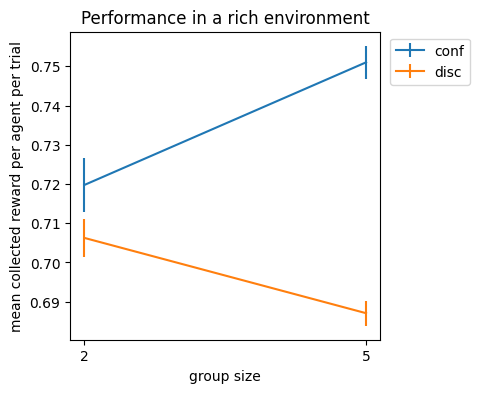

In [ ]:
# Plot results

CI_array = 1.96 * stdR_array / np.sqrt(n_simu)  # confidence intervals

plt.figure(figsize=(4, 4))
plt.errorbar(n_agents, meanR_array[0, 0, :], yerr=CI_array[0, 0, :], label=bias_strength[0])
plt.errorbar(n_agents, meanR_array[0, 1, :], yerr=CI_array[0, 1, :], label=bias_strength[1])
plt.xlabel("group size")
plt.ylabel("mean collected reward per agent per trial")
plt.xticks([2, 5])
plt.legend(bbox_to_anchor=(1.01, 1))
plt.title("Performance in a rich environment")
plt.show()